<a href="https://colab.research.google.com/github/rajaganesh1357/Time_Series_Repository/blob/main/Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [134]:
data = pd.read_csv('https://raw.githubusercontent.com/rajaganesh1357/Time_Series_Repository/main/Electric_Production.csv')
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [136]:
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.rename(columns={"IPG2211A2N":"value"})
data = data.set_index('DATE')
data.head()

,value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [137]:
data.isnull().sum()

value    0
dtype: int64

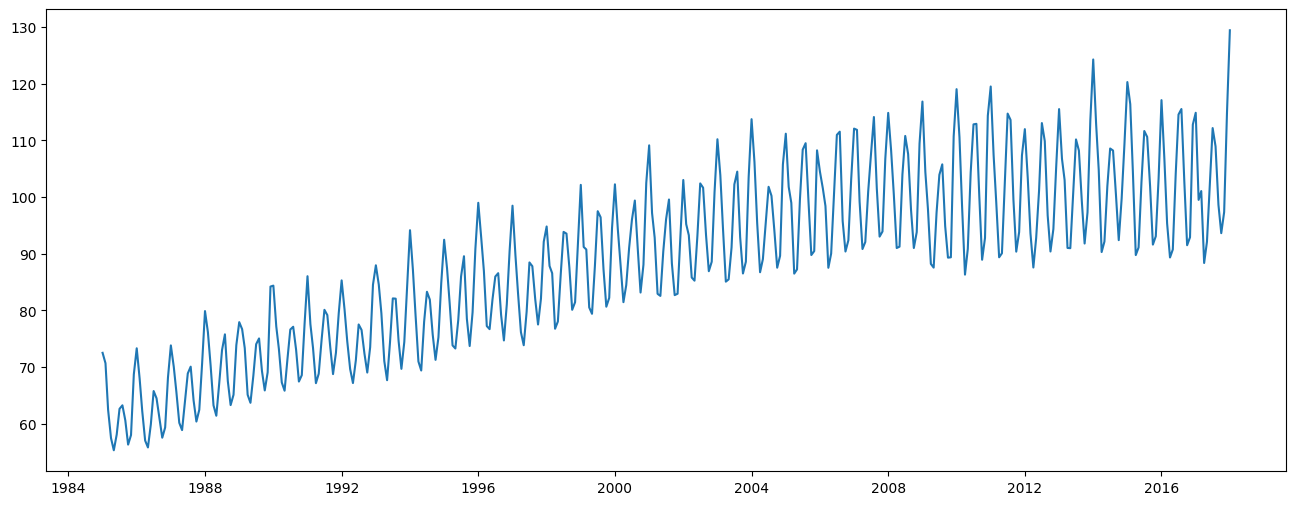

In [138]:
plt.figure(figsize=(16,6))
plt.plot(data)
plt.show()

# **Stationarity**


**ADF**

In [139]:
data_adf = adfuller(data['value'])
print('Test Statistic:', data_adf[0])
print('p-value:', data_adf[1])
print('Critical value:')
for key, value in data_adf[4].items():
 print(key, ':', value)


Test Statistic: -2.256990350047235
p-value: 0.1862146911658712
Critical value:
1% : -3.4476305904172904
5% : -2.869155980820355
10% : -2.570827146203181


The ADF test assesses the stationarity of a time series. If the p-value is below significance level(0.05), we reject the null hypothesis, indicating that the time series is stationary. Conversely, if the p-value exceeds the significance level, we do not reject the null hypothesis, implying that the time series is non-stationary

In [140]:
if data_adf[1]<0.05:
  print("Stationary")
else: print("Not Stationary")

Not Stationary


**KPSS**

In [141]:
data_kpss = kpss(data['value'])
print('Test Statistic:', data_kpss[0])
print('p-value:', data_kpss[1])
print('Critical value:')
for key, value in data_kpss[3].items():
 print(key, ':', value)

Test Statistic: 3.5315970094994853
p-value: 0.01
Critical value:
10% : 0.347
5% : 0.463
2.5% : 0.574
1% : 0.739


<ipython-input-141-3ebfafa91121>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  data_kpss = kpss(data['value'])


In [142]:
if data_kpss[1]>0.05:
  print("Stationary")
else: print("Not Stationary")

Not Stationary


# **Seasonality**

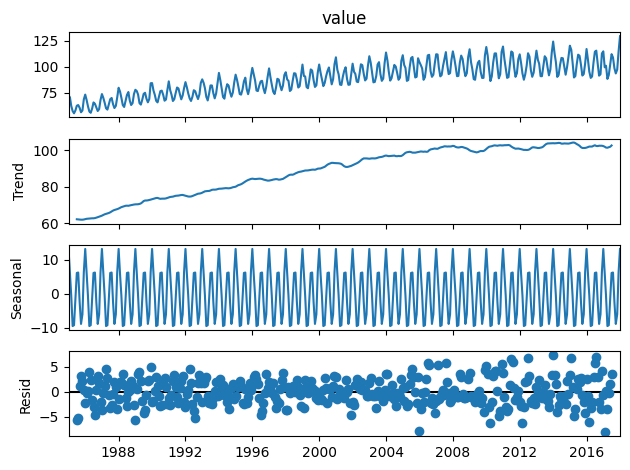

In [143]:
data_sd = seasonal_decompose(data['value'])
data_sd.plot()
plt.show()

In [144]:
data['month'] = data.index.month

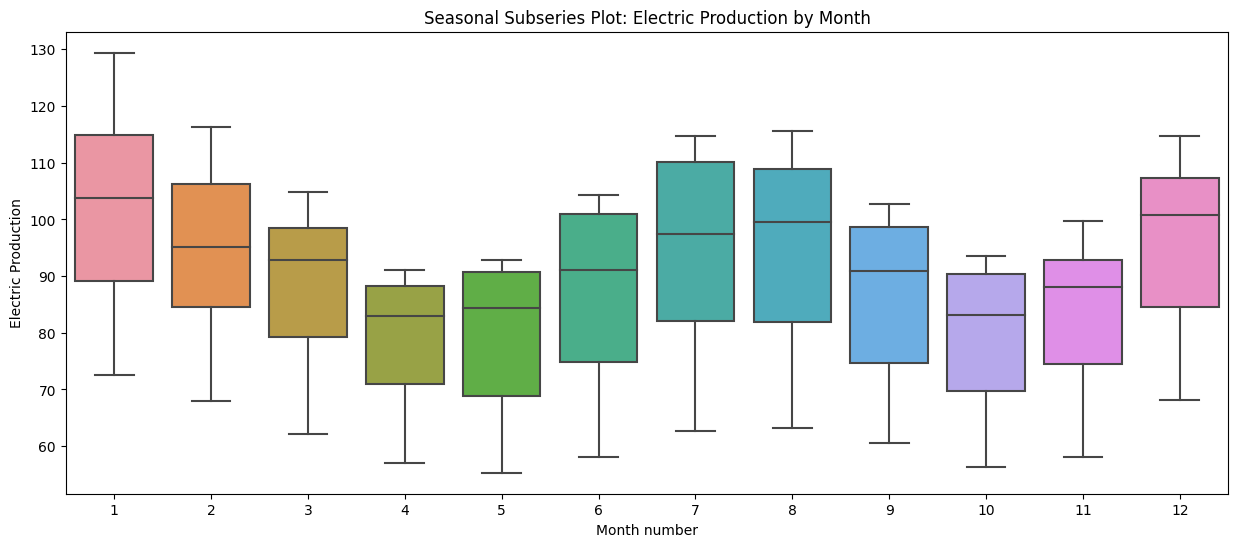

In [145]:
plt.figure(figsize=(15, 6))
sns.boxplot(x=data['month'], y=data['value'])
plt.xlabel('Month number')
plt.ylabel('Electric Production')
plt.title('Seasonal Subseries Plot: Electric Production by Month')
plt.show()

# Autocorrelation

<Figure size 1500x600 with 0 Axes>

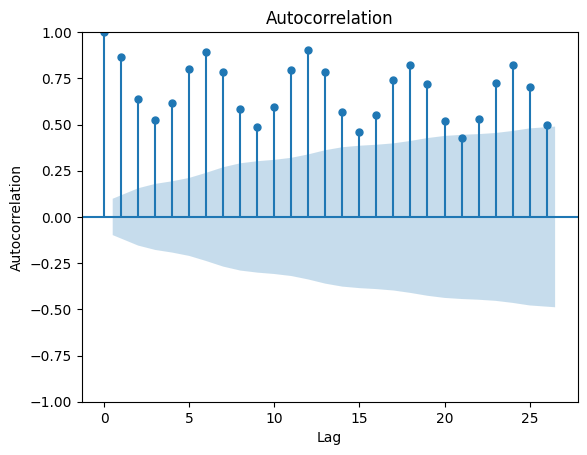

In [146]:
plt.figure(figsize=(15, 6))
plot_acf(data['value'])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

<Figure size 1500x600 with 0 Axes>

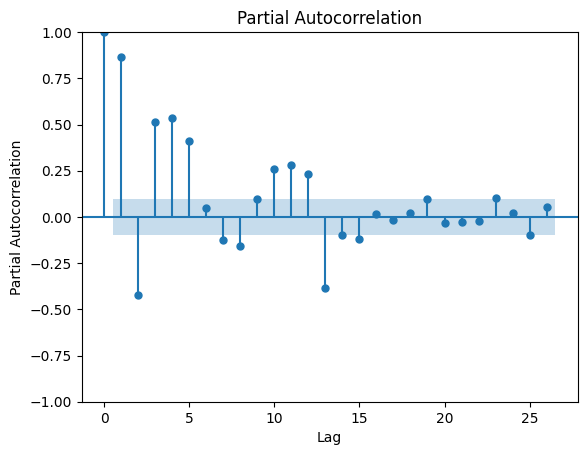

In [147]:
plt.figure(figsize=(15, 6))
plot_pacf(data['value'])
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm

model = pm.auto_arima(data['value'], m=12,
                         seasonal=True,
                      start_p=0, start_q=0, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

In [150]:
data_train,data_test = train_test_split(data['value'],test_size=0.20,random_state=123,shuffle=False)

In [151]:
model.fit(data_train)

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [152]:
data_test.count()

80

In [153]:
data_test.index[0]

Timestamp('2011-06-01 00:00:00')

In [154]:
data_predict = model.predict(n_periods=100,return_conf_int=True)

In [ ]:
data_predict

In [156]:
data_predict_index = pd.date_range(start='2011-06-1',freq='MS',periods=100)

In [157]:
data_predicted_value = pd.DataFrame(data_predict[0],columns=['Predicted'],index=data_predict_index)

In [158]:
data_predicted_value

,Predicted
2011-06-01,102.070805
2011-07-01,110.555733
2011-08-01,111.149046
2011-09-01,99.928803
2011-10-01,91.933990
...,...
2019-05-01,96.575582
2019-06-01,107.076797
2019-07-01,114.555914
2019-08-01,115.274795


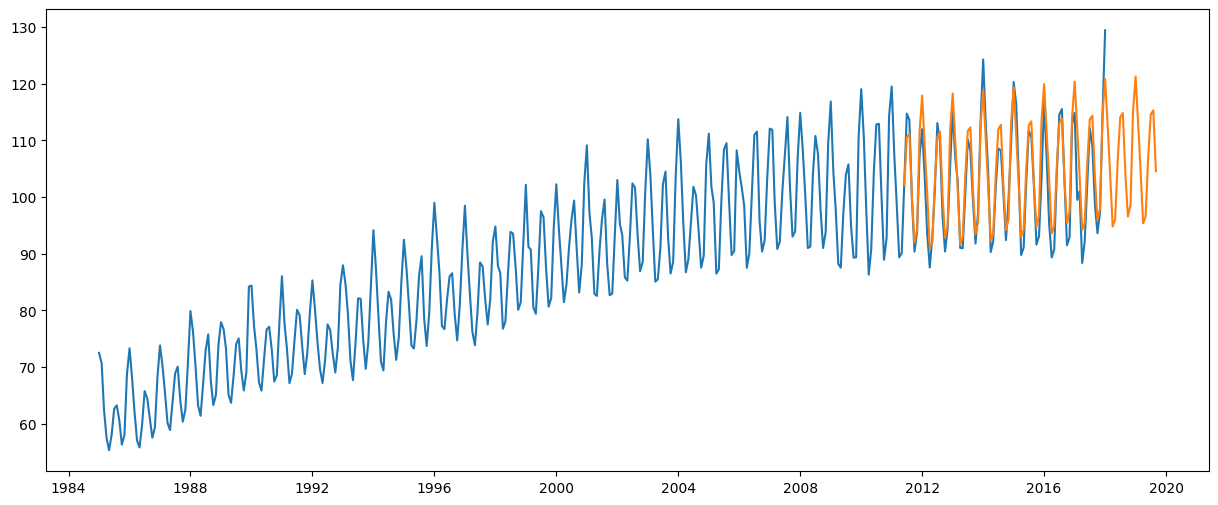

In [159]:
plt.figure(figsize=(15,6))
plt.plot(data['value'])
plt.plot(data_predicted_value)
plt.show()

In [160]:
lower=pd.Series(data_predict[1][:,0])
upper=pd.Series(data_predict[1][:,1])

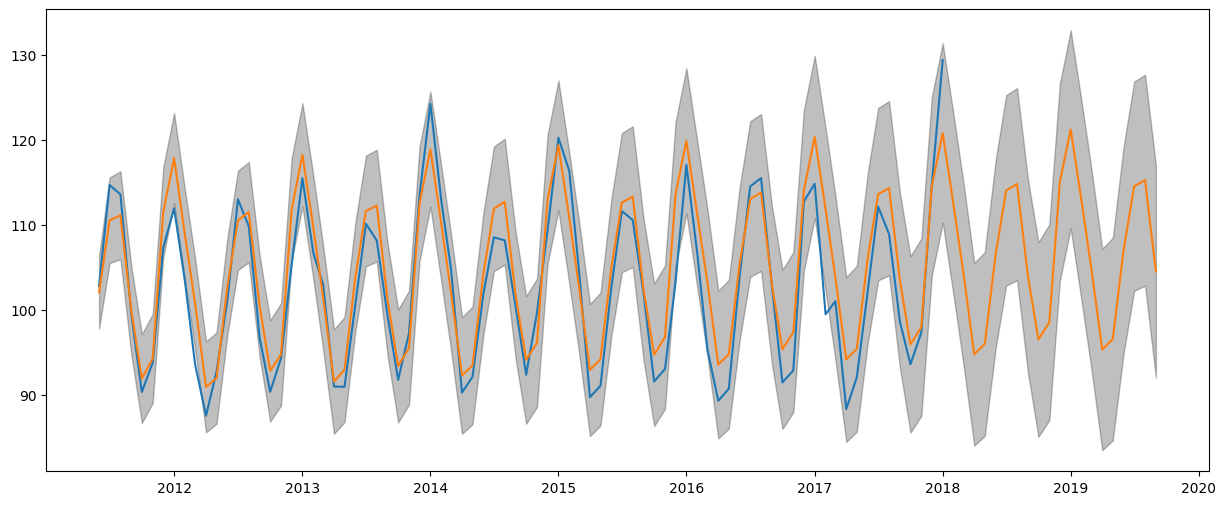

In [161]:
plt.figure(figsize=(15,6))
plt.plot(data_test)
plt.plot(data_predicted_value)
plt.fill_between(data_predict_index,lower,upper,color='k',alpha=.25)
plt.show()

<Figure size 1500x600 with 0 Axes>

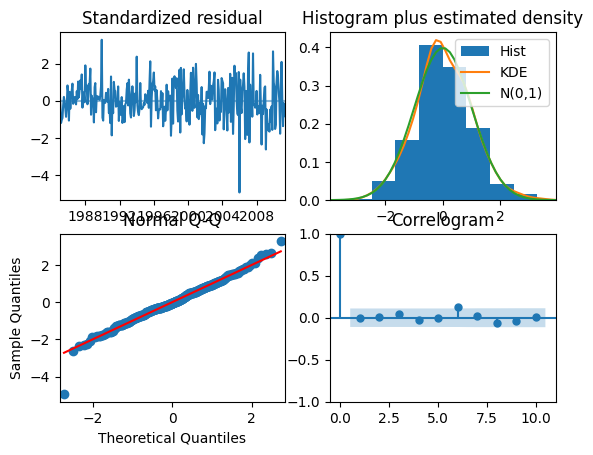

In [162]:
out = model.plot_diagnostics()